<a href="https://colab.research.google.com/github/qiuhuasheng1107/project_pytorch_exercise/blob/main/gold_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.utils.data as data


In [2]:
df = pd.read_csv('gold_price_data.csv')
df.tail()

,Date,Value
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70
10786,2020-03-13,1562.80


In [3]:
len(df)

10787

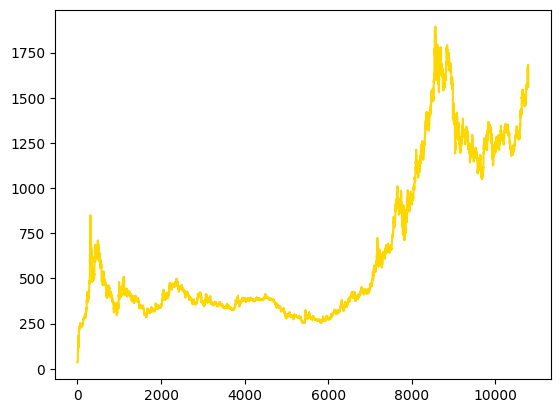

In [4]:
timeseries = df[["Value"]].values.astype('float32')
plt.plot(timeseries, color='gold')
plt.show()

In [5]:
# train-test split for time series
train_size = int(len(timeseries) * 0.70)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(len(train), len(test))

7550 3237


In [6]:
def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset)-window_size):
        feature = dataset[i:i+window_size]
        target = dataset[i+window_size]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [7]:
window_size = 5
X_train, y_train = create_dataset(train, window_size=window_size)
X_test, y_test = create_dataset(test, window_size=window_size)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train

torch.Size([7545, 5, 1]) torch.Size([7545, 1])
torch.Size([3232, 5, 1]) torch.Size([3232, 1])


<ipython-input-6-6f2fa0a26102>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y)


tensor([[ 38.9000],
        [ 40.1000],
        [ 42.0000],
        ...,
        [758.8500],
        [756.7500],
        [762.5000]])

In [8]:
# LSTM Model
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=16, num_layers=1, batch_first=True)
        self.linear = nn.Linear(16, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [9]:
model = LSTM_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128)

In [10]:
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 400.1089, test RMSE 1295.1229
Epoch 100: train RMSE 313.9566, test RMSE 1207.0513
Epoch 200: train RMSE 234.3841, test RMSE 1123.4379
Epoch 300: train RMSE 159.6754, test RMSE 1050.4705
Epoch 400: train RMSE 102.8768, test RMSE 959.6426


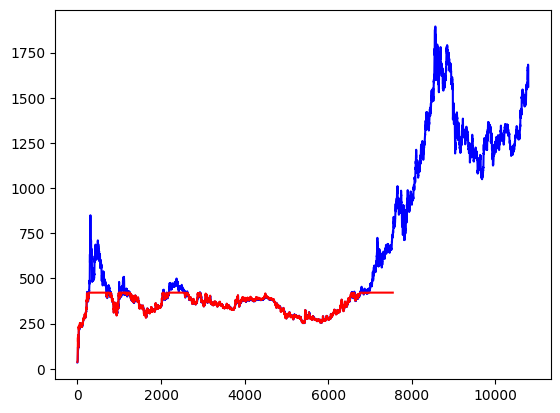

In [15]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = model(X_train)
    # shift test predictions for plotting
    test_plot = model(X_test)
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
#plt.plot(test_plot, c='g')
plt.show()